<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Extreme-Simplicity-Bias-(SB):-Slab-structured-Data" data-toc-modified-id="Extreme-Simplicity-Bias-(SB):-Slab-structured-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Extreme Simplicity Bias (SB): Slab-structured Data</a></span><ul class="toc-item"><li><span><a href="#Training-FCNs-on-LMS-5-(Linear-+-multiple-5-Slabs)-data" data-toc-modified-id="Training-FCNs-on-LMS-5-(Linear-+-multiple-5-Slabs)-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Training FCNs on LMS-5 (Linear + multiple 5-Slabs) data</a></span></li><li><span><a href="#Training-FCNs-on-MS-(5,7)-(5-Slab-+-Multiple-7-Slabs)-data" data-toc-modified-id="Training-FCNs-on-MS-(5,7)-(5-Slab-+-Multiple-7-Slabs)-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training FCNs on MS-(5,7) (5-Slab + Multiple 7-Slabs) data</a></span></li></ul></li></ul></div>

# Extreme Simplicity Bias (SB): Slab-structured Data
Recall that we define extreme simplicity bias (SB) as the tendency of neural networks trained with SGD or variants to learn a small-margin classifier that exclusively relies on the simplest feature and remain invariant to all complex features. 
 
In this notebook, we demonstrate the extreme nature of SB on slab-structured datasets that comprise features varying levels of simplicity: LMS-5 and MS-(5,7). The datasets are described in Section 3 and Section 4 of the [paper](https://arxiv.org/abs/2006.07710) respectively. In LMS-5 and MS-(5,7), the simplest feature corresponds to the linear and 5-slab block whereas the complex features correspond to the 5-slab and 7-slab blocks respectively. We validate this phenomenon using the metrics defined in Section 3 of the [paper](https://arxiv.org/abs/2006.07710) 

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imports import *

DEVICE_ID = 3 # GPU_ID or None (CPU)
DEVICE = gu.get_device(DEVICE_ID)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training FCNs on LMS-5 (Linear + multiple 5-Slabs) data

Text(0.5, 0.98, 'LMS')

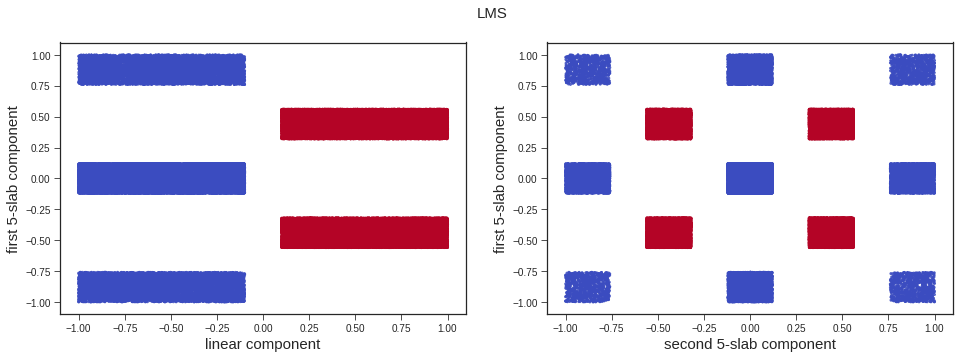

In [15]:
# load and visualize LMS data

c = config =  {
    'num_train': 100_000, # training dataset size
    'dim': 50, # input dimension
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random (orthogonal) transformation
    'width': 1, # data width in standard basis
    'num_lin': 1, # number of linear components
    'num_slabs': 49, #. number of 5 slabs
    'num_slabs7': 0, # number of 7 slabs
    'num_slabs3': 0, # number of 3 slabs
    'bs': 256, # batch size
    'corrupt_lin': 0.0, # p_noise
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'corrupt_slab7': 0.0, # NEW!
    'num_test': 10_000, # test dataset size
    'hdim': 100, # model width
    'hl': 2, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-5 # weight decay
}

data = get_data(**c)

# visualize LMS data
fig, (ax, ax_) = plt.subplots(1,2,figsize=(16, 5))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax.set_xlabel('linear component', fontsize=15)
ax.set_ylabel('first 5-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax_.set_xlabel('second 5-slab component', fontsize=15)
ax_.set_ylabel('first 5-slab component', fontsize=15)
fig.suptitle('LMS', fontsize=15)

In [16]:
# train (100,2)-FCN on LMS data
model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
opt = optim.SGD(model.parameters(), lr=c['lr'], weight_decay=c['weight_decay'])

stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                        data['te_dl'], gap=5000, device=c['device'],
                        epsilon=0.0001, patience_updates=1)

accuracy/loss measured every 5000 updates
update_print_gap: 5000, epss: 0.0001, bs: 256, device: cuda:3
#updates, train acc, test acc, train loss
0 0.5052 0.5050 0.6913


In [5]:
# compute standard, S-randomized and S^c-randomized AUC 
std_auc = utils.get_binary_auc(model, data['te_dl'], c['device'])

# get S-randomized and S^c-randomized datasets 
s_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], [0]) # randomize linear coordinate
sc_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], list(range(1, c['dim']))) # randomize all 49 5-slab coordinates

# compute randomized AUC
s_rand_auc = utils.get_binary_auc(model, s_rand_dl, c['device']) 
sc_rand_auc = utils.get_binary_auc(model, sc_rand_dl, c['device']) 

print ('Standard AUC: {:.3f}'.format(std_auc))
print ('Linear-Randomized or S-Randomized AUC: {:.3f}'.format(s_rand_auc))
print ('Slabs-Randomized or Sc-Randomized AUC: {:.3f}'.format(sc_rand_auc))

Standard AUC: 1.000
Linear-Randomized or S-Randomized AUC: 0.507
Slabs-Randomized or Sc-Randomized AUC: 1.000


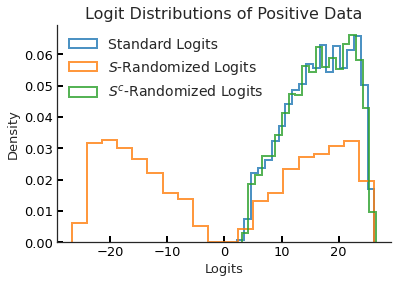

In [6]:
"""
logits "score" distribution of positive data points
The distribution remain essentially the same even after randomizing all complex features (5-slab coordinates)
The logits get randomly shuffled across classes after randomized the linear feature (linear coordinate)
"""
def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

# compute logit scores
std_log = get_logits(model, data['te_dl'], DEVICE)
s_rand_log = get_logits(model, s_rand_dl, DEVICE)
sc_rand_log = get_logits(model, sc_rand_dl, DEVICE)

# plot logit distributions
kw = dict(kde=False, bins=20, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.distplot(std_log, label='Standard Logits', **kw)
ax = sns.distplot(s_rand_log, label=r'$S$-Randomized Logits', **kw)
ax = sns.distplot(sc_rand_log, label=r'$S^c$-Randomized Logits', **kw)

utils.update_ax(ax, 'Logit Distributions of Positive Data', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

As shown above, randomizing the single linear coordinate randomly shuffles the logits across class and nullifies the model's predictive power. The AUC of the trained FCN drops from $100\%$ to $50\%$ (essentially random). On the other hand, randomzing all 49 5-slab coordinates has no effect on AUC or the logit distribution.

Coordinate-wise randomized accuracies:
0:0.508 1:1.000 2:1.000 3:1.000 4:1.000 5:1.000 6:1.000 7:1.000 8:1.000 9:1.000 10:1.000 11:1.000 12:1.000 13:1.000 14:1.000 15:1.000 16:1.000 17:1.000 18:1.000 19:1.000 20:1.000 21:1.000 22:1.000 23:1.000 24:1.000 25:1.000 26:1.000 27:1.000 28:1.000 29:1.000 30:1.000 31:1.000 32:1.000 33:1.000 34:1.000 35:1.000 36:1.000 37:1.000 38:1.000 39:1.000 40:1.000 41:1.000 42:1.000 43:1.000 44:1.000 45:1.000 46:1.000 47:1.000 48:1.000 49:1.000 



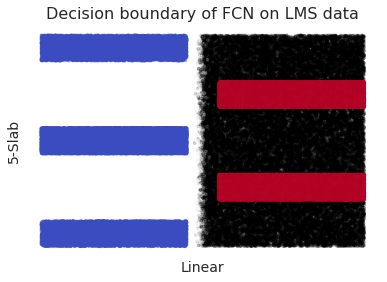

In [7]:
"""
Two-dimensional projection of the model's decision boundary
onto the two most influential coordinates (measured using randomized AUC)
"""
print ("Coordinate-wise randomized accuracies:")
ax = lms_utils.visualize_boundary(model, data, 0, 1, 50, ax=None, is_binary=False, 
                                  width=1, unif_k=True, k=100_000, print_info=True)
utils.update_ax(ax, 'Decision boundary of FCN on LMS data', 'Linear', '5-Slab', 
                title_fs=16, label_fs=14, legend_loc=False)
sns.despine(ax=ax, bottom=True, left=True); ax.set_xticks([]); ax.set_yticks([])
None

## Training FCNs on MS-(5,7) (5-Slab + Multiple 7-Slabs) data

Text(0.5, 0.98, 'MS-(5,7) data')

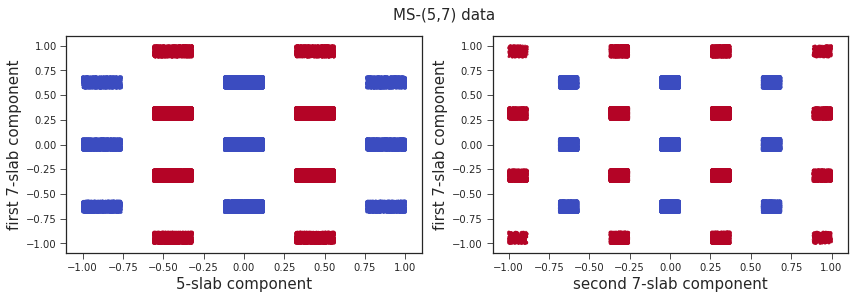

In [8]:
c = config =  {
    'num_train': 100_000, # training dataset size
    'dim': 50, # input dimension
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random transform
    'width': 1, # data width
    'num_lin': 0, # number of linear components
    'num_slabs': 1, #. number of 5-slabs
    'num_slabs7': 49, # number of 7-slabs
    'num_slabs3': 0, # number of 3-slabs
    'bs': 256, # batch size
    'corrupt_lin': 0.0, # p_noise
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 50_000, # test dataset size
    'hdim': 100, # model width
    'hl': 2, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-5 # weight decay
}

data = get_data(**c)

# visualize noisy LMS
fig, (ax, ax_) = plt.subplots(1,2,figsize=(14, 4))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax.set_xlabel('5-slab component', fontsize=15)
ax.set_ylabel('first 7-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) # first coord is linear, second is slab
ax_.set_xlabel('second 7-slab component', fontsize=15)
ax_.set_ylabel('first 7-slab component', fontsize=15)
fig.suptitle('MS-(5,7) data', fontsize=15)

In [9]:
# train (100,2)-FCN on MS-(5,7) data
model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
opt = optim.SGD(model.parameters(), lr=c['lr'], weight_decay=c['weight_decay'])

stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                        data['te_dl'], gap=5000, device=c['device'],
                        epsilon=0.0001, patience_updates=1000)

accuracy/loss measured every 5000 updates
update_print_gap: 5000, epss: 0.0001, bs: 256, device: cuda:0
#updates, train acc, test acc, train loss
0 0.4987 0.4995 0.6935
5000 0.5214 0.5030 0.6928
10000 0.5443 0.5025 0.6897
15000 1.0000 1.0000 0.0023
converged after 38 epochs in 0.0m 53.100310s, gap: 0.0
init-ing patience (1000 updates)
16000 1.0000 1.0000 0.0016


In [10]:
# compute standard, S-randomized and S^c-randomized AUC 
std_auc = utils.get_binary_auc(model, data['te_dl'], c['device'])

# get S-randomized and S^c-randomized datasets
s_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], [0]) # randomize 5-slab coordinate
sc_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], list(range(1, c['dim']))) # randomize all 49 7-slab coordinates

# compute randomized AUC
s_rand_auc = utils.get_binary_auc(model, s_rand_dl, c['device']) 
sc_rand_auc = utils.get_binary_auc(model, sc_rand_dl, c['device']) 

print ('Standard AUC: {:.3f}'.format(std_auc))
print ('(5-Slab)-Randomized or S-Randomized AUC: {:.3f}'.format(s_rand_auc))
print ('(7-Slabs)-Randomized or Sc-Randomized AUC: {:.3f}'.format(sc_rand_auc))

Standard AUC: 1.000
(5-Slab)-Randomized or S-Randomized AUC: 0.502
(7-Slabs)-Randomized or Sc-Randomized AUC: 1.000


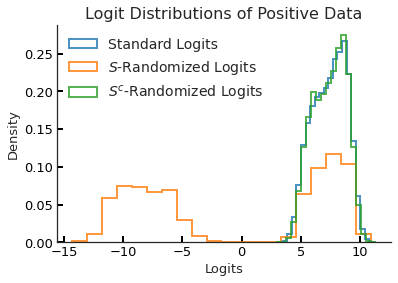

In [11]:
"""
logits "score" distribution of positive data points
The distribution remain essentially the same even after randomizing all complex features (7-slab coordinates)
The logits get randomly shuffled across classes after randomized the linear feature (5-slab coordinate)
"""
def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

# compute logit scores
std_log = get_logits(model, data['te_dl'], DEVICE)
s_rand_log = get_logits(model, s_rand_dl, DEVICE)
sc_rand_log = get_logits(model, sc_rand_dl, DEVICE)

# plot logit distributions
kw = dict(kde=False, bins=20, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.distplot(std_log, label='Standard Logits', **kw)
ax = sns.distplot(s_rand_log, label=r'$S$-Randomized Logits', **kw)
ax = sns.distplot(sc_rand_log, label=r'$S^c$-Randomized Logits', **kw)

utils.update_ax(ax, 'Logit Distributions of Positive Data', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

As shown above, randomizing the single 5-slab coordinate randomly shuffles the logits across class and nullifies the model's predictive power. The AUC of the trained FCN drops from $100\%$ to $50\%$. On the other hand, randomzing all 49 7-slab coordinates has no effect on AUC or the logit distribution.

Coordinate-wise randomized accuracies:
0:0.500 1:1.000 2:1.000 3:1.000 4:1.000 5:1.000 6:1.000 7:1.000 8:1.000 9:1.000 10:1.000 11:1.000 12:1.000 13:1.000 14:1.000 15:1.000 16:1.000 17:1.000 18:1.000 19:1.000 20:1.000 21:1.000 22:1.000 23:1.000 24:1.000 25:1.000 26:1.000 27:1.000 28:1.000 29:1.000 30:1.000 31:1.000 32:1.000 33:1.000 34:1.000 35:1.000 36:1.000 37:1.000 38:1.000 39:1.000 40:1.000 41:1.000 42:1.000 43:1.000 44:1.000 45:1.000 46:1.000 47:1.000 48:1.000 49:1.000 



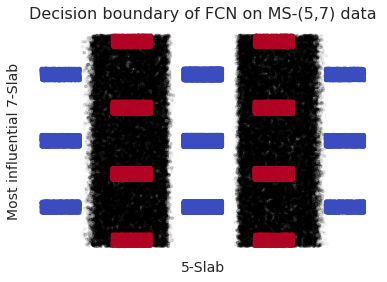

In [12]:
"""
Two-dimensional projection of the model's decision boundary
onto the two most influential coordinates (measured using randomized AUC)
"""
print ("Coordinate-wise randomized accuracies:")
ax = lms_utils.visualize_boundary(model, data, 0, 1, 50, ax=None, width=1, unif_k=True, k=100_000, print_info=True)
utils.update_ax(ax, 'Decision boundary of FCN on MS-(5,7) data', '5-Slab', 'Most influential 7-Slab', 
                title_fs=16, label_fs=14, legend_loc=False)
sns.despine(ax=ax, bottom=True, left=True); ax.set_xticks([]); ax.set_yticks([])
None